# Geometric Low-Rank Tensor Completion

- **Light Geman**

----------------

Geometric Low-rank Tensor Completion (GLTC) is a machine learning model for reconstructing missing values within tensors. In particular, this model can use the graph regularizer (e.g., adjacent smoothness matrix based penalty in this study) to express side information.


## Motivation: Real-World Applications

In the field of computer vision, tensor completion problem arises as as many pixels may be missing in color images.

### Graph in image

The nearby pixels are very similiar. Take the image of Lena as an example:

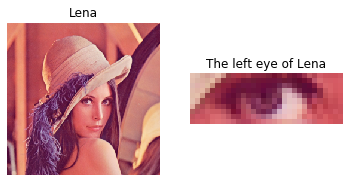

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

lena = imageio.imread('data/lena.bmp')

dim1, dim2, dim3 = lena.shape
a = int(dim1/2)
b = int(dim1/2) + 10
c = int(dim2/2) - 10
d = int(dim2/2) + 20

plt.subplot(1, 2, 1)
plt.imshow(lena)
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lena[a:b, c:d, :])
plt.title('The left eye of Lena')
plt.axis('off')

plt.show()

> Figure 1: Lena and her left eye.

## Selected Images

We carry out our image inpainting experiments on the images of `Lena` and `Peppers`.

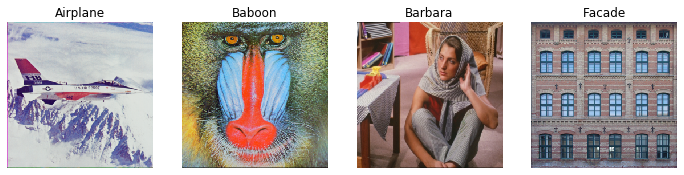

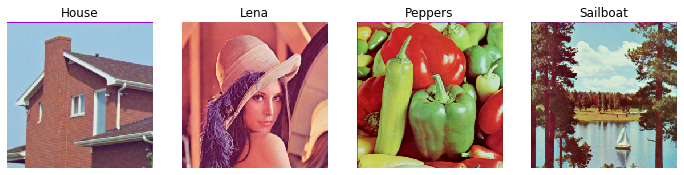

In [3]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('data/airplane.bmp'))
plt.title('Airplane')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('data/baboon.bmp'))
plt.title('Baboon')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('data/barbara.bmp'))
plt.title('Barbara')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('data/facade.bmp'))
plt.title('Facade')
plt.axis('off')

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('data/house.bmp'))
plt.title('House')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('data/lena.bmp'))
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('data/peppers.bmp'))
plt.title('Peppers')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('data/sailboat.bmp'))
plt.title('Sailboat')
plt.axis('off')

plt.show()

## Geometric Low-Rank Tensor Completion

### Preparation

We start by importing the necessary dependencies, and the following defined functions mainly make use of `numpy`.

In [7]:
import numpy as np
from numpy.linalg import inv as inv
import numpy.linalg as ng

Functions for unfolding a tensor into a matrix (`ten2mat`) and folding a matrix into a tensor (`mat2ten`) according to a specific mode:

In [8]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [9]:
def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

### Iterative Reweighted Nuclear Norm (IRNN)

In [28]:
def supergradient(s_hat, lambda0, theta):
    """Supergradient of the Geman function."""
    return (lambda0 * theta / (s_hat + theta) ** 2)

def GLTC_Geman(dense_tensor, sparse_tensor, alpha, beta, rho, theta, maxiter):
    """Main function of GLTC-Geman."""
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    position = np.where(sparse_tensor != 0)
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[position] = 1
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{X}} (n1*n2*3*d)
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    for k in range(dim0):
        X[:, :, :, k] = tensor_hat
    
    D1 = np.zeros((dim1 - 1, dim1))
    for i in range(dim1 - 1):
        D1[i, i] = -1
        D1[i, i+1] = 1
    D2 = np.zeros((dim2 - 1, dim2))
    for i in range(dim2 - 1):
        D2[i, i] = -1
        D2[i, i+1] = 1
    
    for iters in range(maxiter):
        for k in range(dim0):
            Z_hat = ten2mat(X[:, :, :, k] + T[:, :, :, k] / rho, k)
            u, s, v = np.linalg.svd(Z_hat, full_matrices = 0)
            for i in range(len(np.where(s > 0)[0])):
                s[i] = max(s[i] - supergradient(s[i], alpha / rho, theta) / rho, 0)
            var = np.matmul(np.matmul(u, np.diag(s)), v)
            Z[:, :, :, k] = mat2ten(var, np.array([dim1, dim2, dim3]), k)
            if k == 0:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D1.T, D1) + rho * np.eye(dim1)), 
                                         ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)), 
                               np.array([dim1, dim2, dim3]), k)
            elif k == 1:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D2.T, D2) + rho * np.eye(dim2)), 
                                         ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)), 
                               np.array([dim1, dim2, dim3]), k)
            else:
                var0 = Z[:, :, :, k] - T[:, :, :, k] / rho
            X[:, :, :, k] = (np.multiply(1 - binary_tensor, var0) 
                             + np.multiply(binary_tensor, sparse_tensor))
        tensor_hat = np.mean(X, axis = 3)
        for k in range(dim0):
            var = T[:, :, :, k] + rho * (X[:, :, :, k] - Z[:, :, :, k])
            T[:, :, :, k] = var.copy()
            X[:, :, :, k] = tensor_hat.copy()

    return tensor_hat

## Experiments on Color Images

In the following, we will illustrate the performance of image inpainting tasks using Geometric Low-rank Tensor Completion (GLTC) model on some color images.

We set the missing patterns as

- missing at random (MAR), 
- row-wise missing at random (R-MAR),
- column-wise missing at random (C-MAR), 
- (row,column)-wise missing at random (RC-MAR),

and the missing rate as 30%,50%, and 70%. In particular, we carry out the experiment on each image at each specific missing rate for 50 times.

The recovery performance is measured by $$\text{RSE}=\frac{\|\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{X}})-\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{Y}})\|_{F}}{\|\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{Y}})\|_{F}}\times 100.$$

### Evaluated on `lena` and `peppers`

Here, it is convenient to import the image under a certain missing pattern at the 50% missing rate. For example, on the image `Lena`, we could choose

- `lena_mar`
- `lena_rmar`
- `lena_cmar`
- `lena_rcmar`

In [29]:
import imageio

name0 = ["lena"]
name = ["lena_mar"]
image = imageio.imread('data/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('data/{}.bmp'.format(name[0]))

In [30]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
theta = 2
alpha = 10
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
image_hat = GLTC_Geman(image, sparse_image, alpha, beta, rho, theta, maxiter)
image_rec = np.round(image_hat).astype(int)
image_rec[np.where(image_rec > 255)] = 255
image_rec[np.where(image_rec < 0)] = 0
pos = np.where((image != 0) & (sparse_image == 0))
rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
imageio.imwrite('data/GLTC_capped_L1_{}.jpg'.format(name[0]), np.uint8(image_rec))
print(100 * rse)

6.740749319088607


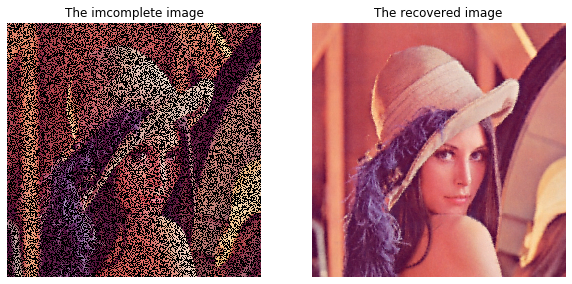

In [31]:
plt.subplots(1, 2, figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.imshow(sparse_image)
plt.title('The imcomplete image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_rec)
plt.title('The recovered image')
plt.axis('off')
plt.show()

Table 1-1: **Experiment results** (RSE performance) of image inpainting for `lena` and `peppers` using GLTC-Geman:

|  Images   |      MAR      |     R-MAR      |   C-MAR   |     RC-MAR     |
|:----------|--------------:|---------------:|----------:|---------------:|
| **lena**  |     6.79      |       8.41     |   11.02   |      8.51      |
|**peppers**|     7.80      |      11.22     |   12.15   |      9.73      |


### Whole Performance

We choose the images of `lena` and `peppers` for evaluation.

#### MAR (Missing at random)

In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
theta = 2
alpha = 10
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["lena"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask = np.round(np.random.rand(dim1, dim2) + 0.5 - rate)  # Generate a binary mask.
            sparse_image = image.copy()
            for k in range(dim3):
                sparse_image[:, :, k] = np.multiply(image[:, :, k], mask) # Generate incomplete image
            image_hat = GLTC_Geman(image, sparse_image, alpha, beta, rho, theta, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
            if (it + 1) % 10 == 0:
                print('Image: %s, Missing level: %d, iteration: %d'%(im[ima], (missing + 1), (it + 1)))

In [ ]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()
print('Totle time consumption: %d'%(time.time() - start_time))

#### R-MAR (Row-wise missing at random)

In [12]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time

theta = 2
alpha = 10
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
start_time = time.time()
timenow = time.time()
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_row = np.round(np.random.rand(dim1) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim2):
                for j in range(dim3):
                    image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = GLTC_Geman(image, sparse_image, beta, rho, maxiter, alpha, theta)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
            if (it + 1) % 5 == 0:
                timeCons = time.time() - timenow
                print('Image: %s, missing level: %d, iteration: %d, 5 picture time consumption: %d'%(im[ima], (missing + 1), (it + 1), timeCons))
                timenow = time.time()

Image: lena, missing level: 1, iteration: 10
Image: lena, missing level: 1, iteration: 20
Image: lena, missing level: 1, iteration: 30
Image: lena, missing level: 1, iteration: 40
Image: lena, missing level: 1, iteration: 50
Image: lena, missing level: 2, iteration: 10
Image: lena, missing level: 2, iteration: 20
Image: lena, missing level: 2, iteration: 30
Image: lena, missing level: 2, iteration: 40
Image: lena, missing level: 2, iteration: 50
Image: lena, missing level: 3, iteration: 10
Image: lena, missing level: 3, iteration: 20
Image: lena, missing level: 3, iteration: 30
Image: lena, missing level: 3, iteration: 40
Image: lena, missing level: 3, iteration: 50
Image: peppers, missing level: 1, iteration: 10
Image: peppers, missing level: 1, iteration: 20
Image: peppers, missing level: 1, iteration: 30
Image: peppers, missing level: 1, iteration: 40
Image: peppers, missing level: 1, iteration: 50
Image: peppers, missing level: 2, iteration: 10
Image: peppers, missing level: 2, ite

In [14]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()
print('Totle time consumption: %d'%(time.time() - start_time))

[[ 7.1200512   8.60556618 12.89038433]
 [ 9.23879136 11.24489482 16.34365288]]

[[0.39045216 0.79627458 3.47344129]
 [0.77097279 0.92124126 3.38134472]]


#### C-MAR (Column-wise missing at random)

#### C-MAR whole test on 'lena'

In [7]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time

theta = 2
alpha = 10
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["lena"]
result = np.zeros((len(im), 3, 50))
start_time = time.time()
timenow = time.time()
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_column = np.round(np.random.rand(dim2) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim1):
                for j in range(dim3):
                    image0[i, :, j] = np.multiply(image[i, :, j], mask_column)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = GLTC_Geman(image, sparse_image, beta, rho, maxiter, alpha, theta)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
            if (it + 1) % 10 == 0:
                timeCons = time.time() - timenow
                print('Image: %s, missing level: %d, iteration: %d, 10 picture time consumption: %d'%(im[ima], (missing + 1), (it + 1), timeCons))
                timenow = time.time()

Image: lena, missing level: 1, iteration: 10, 10 picture time consumption: 1304
Image: lena, missing level: 1, iteration: 20, 10 picture time consumption: 1253
Image: lena, missing level: 1, iteration: 30, 10 picture time consumption: 1157
Image: lena, missing level: 1, iteration: 40, 10 picture time consumption: 1153
Image: lena, missing level: 1, iteration: 50, 10 picture time consumption: 1152
Image: lena, missing level: 2, iteration: 10, 10 picture time consumption: 1149
Image: lena, missing level: 2, iteration: 20, 10 picture time consumption: 1169
Image: lena, missing level: 2, iteration: 30, 10 picture time consumption: 1153
Image: lena, missing level: 2, iteration: 40, 10 picture time consumption: 1153
Image: lena, missing level: 2, iteration: 50, 10 picture time consumption: 1154
Image: lena, missing level: 3, iteration: 10, 10 picture time consumption: 1147
Image: lena, missing level: 3, iteration: 20, 10 picture time consumption: 1152
Image: lena, missing level: 3, iteration

In [8]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()
print('Totle time consumption: %d'%(time.time() - start_time))

[[ 8.54996422 10.42369997 14.69349629]]

[[0.43623639 0.77813688 2.96838499]]

Totle time consumption: 17544


#### C-MAR whole test on 'peppers'

In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time

theta = 2
alpha = 10
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["peppers"]
result = np.zeros((len(im), 3, 50))
start_time = time.time()
timenow = time.time()
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_column = np.round(np.random.rand(dim2) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim1):
                for j in range(dim3):
                    image0[i, :, j] = np.multiply(image[i, :, j], mask_column)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = GLTC_Geman(image, sparse_image, beta, rho, maxiter, alpha, theta)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
            if (it + 1) % 10 == 0:
                timeCons = time.time() - timenow
                print('Image: %s, missing level: %d, iteration: %d, 10 picture time consumption: %d'%(im[ima], (missing + 1), (it + 1), timeCons))
                timenow = time.time()

In [ ]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()
print('Totle time consumption: %d'%(time.time() - start_time))

#### RC-MAR

#### RC-MAR whole test on 'lena'

In [16]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time

theta = 2
alpha = 10
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["lena"]
result = np.zeros((len(im), 3, 50))
start_time = time.time()
timenow = time.time()
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_row = np.round(np.random.rand(dim1) + 0.5 - (1 - np.sqrt(1 - rate)))
            mask_column = np.round(np.random.rand(dim2) + 0.5 - (1 - np.sqrt(1 - rate)))
            image0 = image.copy()
            for i in range(dim2):
                for j in range(dim3):
                    image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
            sparse_image = image0.copy() # Generate incomplete image
            for i in range(dim1):
                for j in range(dim3):
                    sparse_image[i, :, j] = np.multiply(image0[i, :, j], mask_column)
            image_hat = GLTC_Geman(image, sparse_image, beta, rho, maxiter, alpha, theta)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
            if (it + 1) % 10 == 0:
                timeCons = time.time() - timenow
                print('Image: %s, missing level: %d, iteration: %d, 10 picture time consumption: %d'%(im[ima], (missing + 1), (it + 1), timeCons))
                timenow = time.time()

Image: lena, missing level: 1, iteration: 10, 10 picture time consumption: 1157
Image: lena, missing level: 1, iteration: 20, 10 picture time consumption: 1102
Image: lena, missing level: 1, iteration: 30, 10 picture time consumption: 1105
Image: lena, missing level: 1, iteration: 40, 10 picture time consumption: 1080
Image: lena, missing level: 1, iteration: 50, 10 picture time consumption: 1074
Image: lena, missing level: 2, iteration: 10, 10 picture time consumption: 1075
Image: lena, missing level: 2, iteration: 20, 10 picture time consumption: 1074
Image: lena, missing level: 2, iteration: 30, 10 picture time consumption: 1077
Image: lena, missing level: 2, iteration: 40, 10 picture time consumption: 1073
Image: lena, missing level: 2, iteration: 50, 10 picture time consumption: 1077
Image: lena, missing level: 3, iteration: 10, 10 picture time consumption: 1066
Image: lena, missing level: 3, iteration: 20, 10 picture time consumption: 1070
Image: lena, missing level: 3, iteration

In [17]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()
print('Totle time consumption: %d'%(time.time() - start_time))

[[ 7.6107124   8.44734556 10.04875335]]

[[0.43252816 0.44087399 0.74235816]]

Totle time consumption: 16247


### RC-MAR whole test on 'peppers'

In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time

theta = 2
alpha = 10
rho = 0.01
beta = 0.1 * rho
maxiter = 1000
im = ["peppers"]
result = np.zeros((len(im), 3, 50))
start_time = time.time()
timenow = time.time()
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_row = np.round(np.random.rand(dim1) + 0.5 - (1 - np.sqrt(1 - rate)))
            mask_column = np.round(np.random.rand(dim2) + 0.5 - (1 - np.sqrt(1 - rate)))
            image0 = image.copy()
            for i in range(dim2):
                for j in range(dim3):
                    image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
            sparse_image = image0.copy() # Generate incomplete image
            for i in range(dim1):
                for j in range(dim3):
                    sparse_image[i, :, j] = np.multiply(image0[i, :, j], mask_column)
            image_hat = GLTC_Geman(image, sparse_image, beta, rho, maxiter, alpha, theta)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2)/np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
            if (it + 1) % 10 == 0:
                timeCons = time.time() - timenow
                print('Image: %s, missing level: %d, iteration: %d, 10 picture time consumption: %d'%(im[ima], (missing + 1), (it + 1), timeCons))
                timenow = time.time()

In [ ]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()
print('Totle time consumption: %d'%(time.time() - start_time))

Table 1-2: **Experiment results** (RSE performance) of image inpainting on two color images using GLTC-Geman:

|   -  | Scenario |      MAR      |     R-MAR      |   C-MAR   |     RC-MAR     |
|:-----|:----------|--------------:|---------------:|----------:|---------------:|
| **Lena** | **30%**   |     6.06$\pm$0.07      |       7.12$\pm$0.39     |  ~     |       ~     |
|   -  | **50%**   |     6.86$\pm$0.07      |      8.61$\pm$0.79     | ~     |       ~     |
|   -  | **70%**   |     8.07$\pm$0.08      |      12.89$\pm$3.47     |   ~     |      ~     |
| **Peppers** | **30%**   |     6.68$\pm$0.10      |       9.24$\pm$0.77     |  ~     |       ~     |
|   -  | **50%**   |     7.71$\pm$0.08      |      11.24$\pm$0.92     | ~     |       ~     |
|   -  | **70%**   |     9.33$\pm$0.09      |      16.34$\pm$3.38     | ~     |      ~     |